In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from src.dm import DFModule


dm = DFModule(batch_size=4)

dm.setup()

train: 8689
test: 2773


In [23]:
dl = dm.train_dataloader()
s1, s2, labels = next(iter(dl))

s1.shape, s1.dtype, s1.min(), s1.max(), s2.shape, s2.dtype, s2.min(), s2.max(), labels.shape, labels.dtype, labels.min(), labels.max()

(torch.Size([4, 2, 256, 256]),
 torch.float32,
 tensor(-0.),
 tensor(0.9882),
 torch.Size([4, 3, 256, 256]),
 torch.float32,
 tensor(0.),
 tensor(1.),
 torch.Size([4, 256, 256]),
 torch.float32,
 tensor(0.),
 tensor(0.0334))

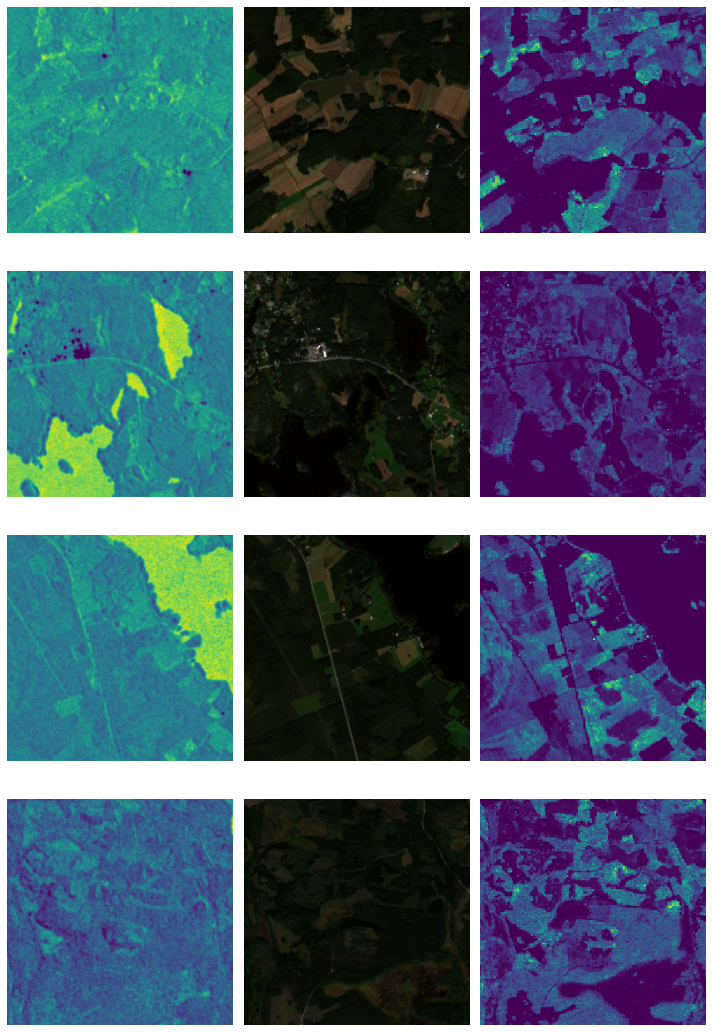

In [32]:
import matplotlib.pyplot as plt 

# plot and 4x4 grid of images
fig, ax = plt.subplots(4, 3, figsize=(10, 15))
dl = dm.train_dataloader()
s1, s2, labels = next(iter(dl))
for i in range(4):
	ax[i, 0].imshow(s1[i][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2[i].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(labels[i])
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [36]:
trans = {
	'HorizontalFlip': {'p': 0.5},
	'VerticalFlip': {'p': 0.5},
	'RandomRotate90': {'p': 0.5},
	'Transpose': {'p': 0.5}
}

dm = DFModule(batch_size=8, train_trans=trans)
dm.setup()

train: 8689
test: 2773


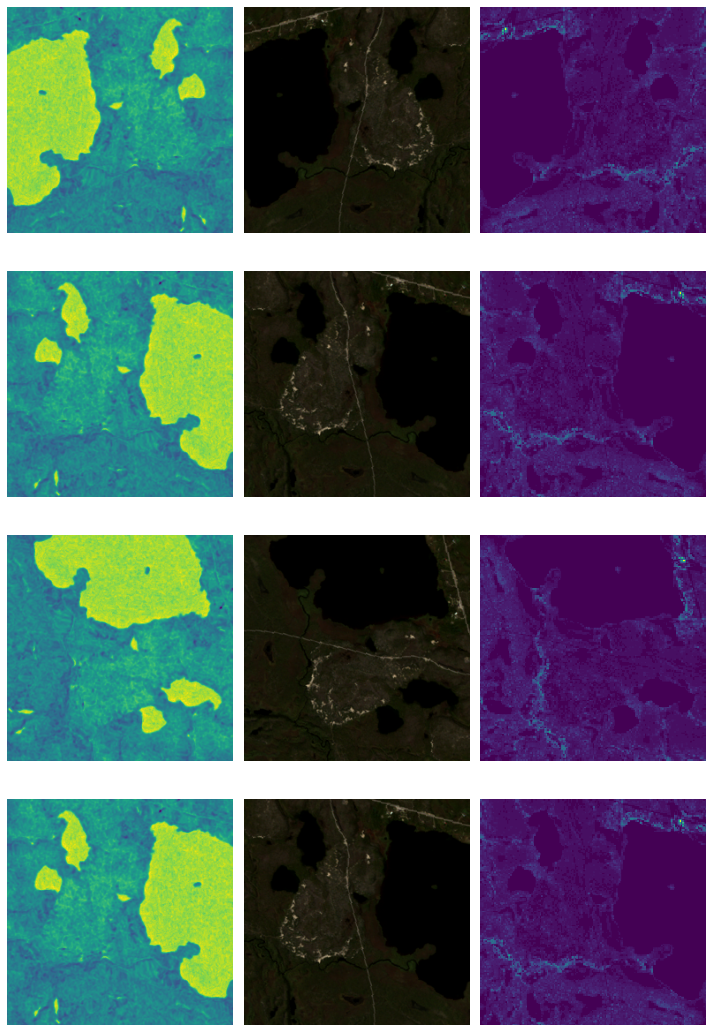

In [39]:
fig, ax = plt.subplots(4, 3, figsize=(10, 15))
for i in range(4):
	dl = dm.train_dataloader(shuffle=False)
	s1, s2, labels = next(iter(dl))
	ax[i, 0].imshow(s1[0][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2[0].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(labels[0])
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [73]:
from src.module import UNetDF
import torch 

hparams = {
	'encoder': 'resnet34',
	'pretrained': "imagenet",
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetDF(hparams)

module

UNetDF(
  (encoder1): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Overfit batches

In [86]:
import pytorch_lightning as pl
import torch

# dm = BaseDataModule(batch_size=4, sensor='S1', bands=(0, 1))
dm = DFModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}


module = UNetDF(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | ResNetEncoder    | 11.2 M
1 | encoder2          | ResNetEncoder    | 11.2 M
2 | decoder           | UnetDecoder      | 5.1 M 
3 | segmentation_head | SegmentationHead | 145   
-------------------------------------------------------
27.5 M    Trainable params
0         Non-trainable params
27.5 M    Total params
54.948    Total estimated model params size (MB)
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers 

Training: 0it [00:00, ?it/s]

In [87]:
dl = dm.train_dataloader(shuffle=False)
s1, s2, labels = next(iter(dl))
preds = module.predict(s1, s2)

preds.shape, preds.dtype, preds.min(), preds.max()

(torch.Size([4, 256, 256]), torch.float32, tensor(2.7760e-07), tensor(0.0410))

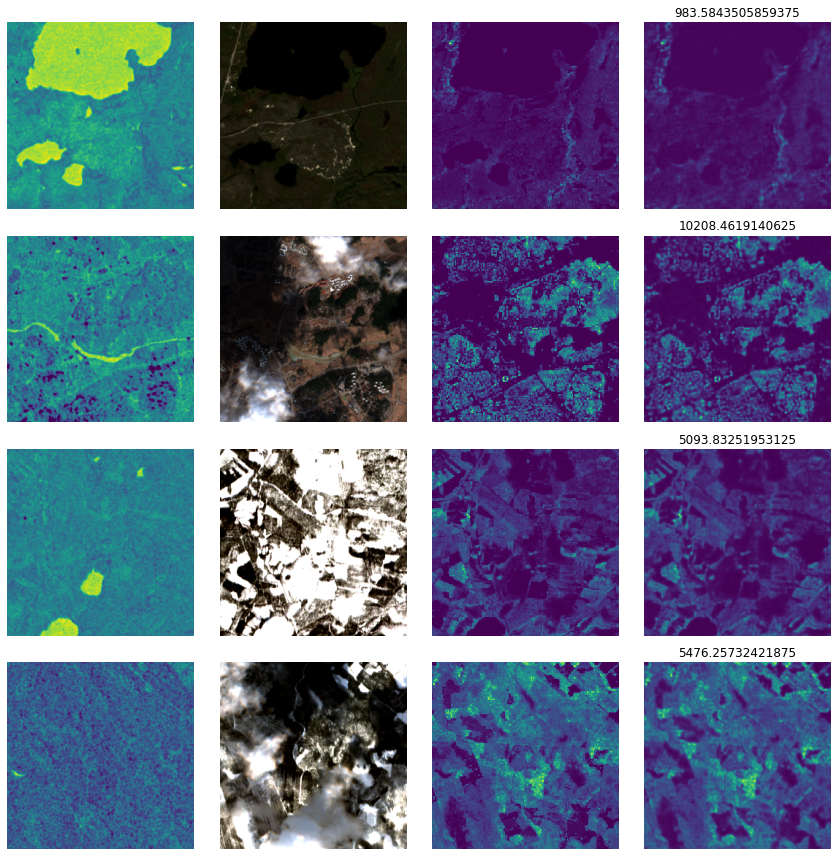

: 

In [88]:
import torch 

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
	ax[i, 0].imshow(s1[i][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2[i].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(labels[i])
	ax[i, 2].axis('off')
	ax[i, 3].imshow(preds[i])
	ax[i, 3].axis('off')
	ax[i, 3].set_title(torch.sqrt(
            torch.sum((preds[i]*12905.3 - labels[i]*12905.3)**2)).item())
plt.tight_layout()
plt.show()